#**NETFLIX RECOMMMENDOR SYSTEM**

**Recommendation Engines are the much
needed manifestations of the desired
Predictability of User Activity.
Recommendation Engines move one step
further and not only give information but
put forth strategies to further increase users
interaction with the platform**

**PROBLEM STATEMENT:**
**For the purpose of this Project we will be
creating one such Recommendation Engine
from the ground-up, where every single user,
based on there area of interest and ratings,
would be recommended a list of movies that
are best suited for them.**


In [1]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# downloading data file
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/combined_data_1.txt',names=['CustomerId','Rating'],usecols=[0,1])
data.head()

CustomerId  Rating
0         1:     NaN
1    1488844     3.0
2     822109     5.0
3     885013     4.0
4      30878     4.0

In [4]:
data.shape

(24058263, 2)

In [5]:
data.isnull().sum()

CustomerId       0
Rating        4499
dtype: int64

In [6]:
# It means there are 4999 movie Id

#**Exploratory Data Analysis**

In [7]:
#calculating movie count

movie_count=data.isnull().sum()
movie_count=movie_count['Rating']

In [8]:
# calculate unique customer Ids

cust_id=data['CustomerId'].nunique()
cust_id=cust_id-movie_count
cust_id

470758

In [9]:
# Total ratings given by customers

ratings=data.shape[0]-movie_count
ratings

24053764

In [10]:
# to find out how many people have give the diferent ratings

Ratings=data.groupby('Rating')['Rating'].agg(['count'])
Ratings

count
Rating         
1.0     1118186
2.0     2439073
3.0     6904181
4.0     8085741
5.0     5506583

<Figure size 1000x800 with 0 Axes>

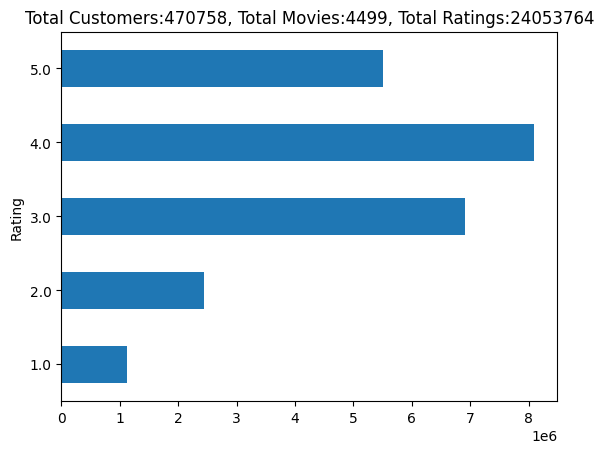

In [11]:
plt.figure(figsize=(10,8))
Ratings.plot(kind='barh',legend=False)
plt.title(f'Total Customers:{cust_id}, Total Movies:{movie_count}, Total Ratings:{ratings}')
plt.plot()
plt.show()

#**Data Preprocessing**

In [12]:
# Now, make a dataframe of null values with their indexes

df_nan=pd.DataFrame(pd.isnull(data['Rating']))
df_nan=df_nan[df_nan['Rating']==True]
df_nan=df_nan.reset_index()
df_nan

index  Rating
0            0    True
1          548    True
2          694    True
3         2707    True
4         2850    True
...        ...     ...
4494  24046714    True
4495  24047329    True
4496  24056849    True
4497  24057564    True
4498  24057834    True

[4499 rows x 2 columns]

In [13]:
# make an array of movie ids

movie_arr=[]
movie_id=1

for i,j in zip(df_nan.iloc[1:,0],df_nan.iloc[:-1,0]):
  array=np.full((1,i-j-1),movie_id)
  movie_arr=np.append(movie_arr,array)
  movie_id+=1

# append the array with last movie id
last_record=np.full((1,len(data)-df_nan.iloc[-1,0]-1),movie_id)
movie_arr=np.append(movie_arr,last_record)

In [14]:
# dropping null values from the data

data=data.dropna()
data['movie_id']=movie_arr.astype('int')
data['CustomerId']=data['CustomerId'].astype('int')
data.head()

CustomerId  Rating  movie_id
1     1488844     3.0         1
2      822109     5.0         1
3      885013     4.0         1
4       30878     4.0         1
5      823519     3.0         1

In [15]:
# Now, we will filter the datatset based on customers that rated less movies & the movies that has been rated less

In [16]:
# movies that are rated less times

# dataframe of movie_id counts
movies=pd.DataFrame(data['movie_id'].value_counts())

# setting a benchmark value
benchmark=np.round(movies.quantile(0.7),0).values[0]

# list of indexes exceeds benchmark
movies_list=list(movies[movies['movie_id']>=benchmark].index)

In [18]:
benchmark

1799.0

In [19]:
len(movies_list)

1350

In [20]:
# customers that rated less movies

# dataframe of customer_id counts
users=pd.DataFrame(data['CustomerId'].value_counts())

# setting a benchmark
benchmark_users=np.round(users.quantile(0.7),0).values[0]

# list of indexes exceeds benchmark
users_list=list(users[users['CustomerId']>=benchmark_users].index)

In [21]:
benchmark_users

52.0

In [22]:
len(users_list)

143458

In [23]:
print('Shape of original data: ',data.shape)

Shape of original data:  (24053764, 3)


In [24]:
# getting the indexes only obtained from above results

data=data[data['movie_id'].isin(movies_list)]
data=data[data['CustomerId'].isin(users_list)]
print('Shape of data after trimming is: ',data.shape)

Shape of data after trimming is:  (17337458, 3)


In [25]:
# importing movies dataset
movies_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movie_titles _1_ (2).csv',encoding='ISO-8859-1',header=None,usecols=[0,1,2],
            names=['movie_id','Year','name'])

# setting index to movie_id
movies_data.set_index('movie_id',inplace=True)

In [26]:
movies_data.shape

(17769, 2)

In [27]:
movies_data.head()

Year                          name
movie_id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW

#**Data Modelling**

**Create Model that finds the best suited Movie for one user in every genre.**

In [28]:
#installing surprise library
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163000 sha256=ec0d1c82ff82f91a76e927c3db2606daa62b3ed0cb3ebbc66c4978a394e966d3
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [29]:
from surprise import Reader,Dataset,SVD
from surprise.model_selection import cross_validate

In [31]:
# read the dataset

reader=Reader()
df=Dataset.load_from_df(data[['CustomerId','movie_id','Rating']],reader)


In [32]:
df

In [33]:
model=SVD()
cross_validate(model,df,measures=['RMSE','MSE'],cv=5)

{'test_rmse': array([0.84864357, 0.84799838, 0.84780396, 0.84757565, 0.84808489]),
 'test_mse': array([0.7201959 , 0.71910125, 0.71877155, 0.71838449, 0.71924797]),
 'fit_time': (440.2843496799469,
  468.07554745674133,
  466.4372978210449,
  470.9352126121521,
  473.43552017211914),
 'test_time': (112.39200758934021,
  135.56913352012634,
  88.40912675857544,
  116.43218541145325,
  85.57209038734436)}

In [34]:
data.head()

CustomerId  Rating  movie_id
696      712664     5.0         3
697     1331154     4.0         3
698     2632461     3.0         3
699       44937     5.0         3
700      656399     4.0         3

#**Prediction for any User**

In [35]:
user_656399=movies_data.copy()
user_656399=user_656399.reset_index()
user_656399=user_656399[user_656399['movie_id'].isin(movies_list)]
user_656399

movie_id    Year                        name
2            3  1997.0                   Character
7            8  2004.0  What the #$*! Do We Know!?
15          16  1996.0                   Screamers
16          17  2005.0                   7 Seconds
17          18  1994.0            Immortal Beloved
...        ...     ...                         ...
4487      4488  2000.0                 Wonder Boys
4489      4490  2004.0                   Ned Kelly
4491      4492  2004.0                  Club Dread
4492      4493  2003.0           Ju-on: The Grudge
4495      4496  1993.0       Farewell My Concubine

[1350 rows x 3 columns]

 **Find out the list of most popular and liked genre**

In [37]:
# Estimated ratings for user

user_656399['Estimate_score']=user_656399['movie_id'].apply(lambda x:model.predict(656399,x).est)
user_656399=user_656399.sort_values('Estimate_score',ascending=False)

**Find what Genre Movies have received the best and
worst ratings based on User Rating**

In [38]:
# Top 10 recommended movies
user_656399.head(10)

movie_id    Year                              name  Estimate_score
1946      1947  2002.0           Gilmore Girls: Season 3        4.424004
1475      1476  2004.0          Six Feet Under: Season 4        4.399321
773        774  2003.0                Foyle's War: Set 2        4.389670
2802      2803  1995.0               Pride and Prejudice        4.333856
269        270  2001.0        Sex and the City: Season 4        4.272307
4344      4345  2002.0             Bowling for Columbine        4.256757
3768      3769  2004.0  Wonderfalls: The Complete Series        4.230679
721        722  2003.0                The Wire: Season 1        4.222720
67          68  2004.0                       Invader Zim        4.208900
733        734  1992.0                         Indochine        4.193140

In [39]:
user_656399.tail(10)

movie_id    Year                                   name  Estimate_score
2667      2668  2001.0                               The Wash        1.330103
4135      4136  1993.0       Teenage Mutant Ninja Turtles III        1.315769
3919      3920  1998.0  I Still Know What You Did Last Summer        1.275173
1974      1975  2000.0                             Hollow Man        1.254468
3935      3936  1999.0                            End of Days        1.225239
2199      2200  2002.0                      Collateral Damage        1.201156
1601      1602  2000.0                     Dungeons & Dragons        1.194289
1292      1293  1996.0  Children of the Corn 4: The Gathering        1.175485
3504      3505  2001.0                    Freddy Got Fingered        1.003938
3020      3021  2003.0                      House of the Dead        1.000000